Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine
import xgboost as xgb


Koneksi ke Database

In [2]:
engine = create_engine("mysql+pymysql://root:@localhost/magang")
query = """
SELECT waktu, voltage, current, power, frequency, powerfactor
FROM meter_1
"""
df = pd.read_sql(query, con=engine)
df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')
print(f"Jumlah Baris = {df.shape[0]}")
display(df.head())


Jumlah Baris = 3100


,voltage,current,power,frequency,powerfactor
waktu,,,,,
2025-01-28 07:41:46,380.78,32.03,20.58,49.98,0.97
2025-01-28 07:41:48,380.78,32.03,20.52,49.98,0.97
2025-01-28 07:41:55,380.35,31.99,20.52,49.98,0.97
2025-01-28 07:42:01,380.35,31.99,20.53,49.98,0.97
2025-01-28 07:42:04,380.49,31.97,20.53,49.99,0.97


Visualisasi Data

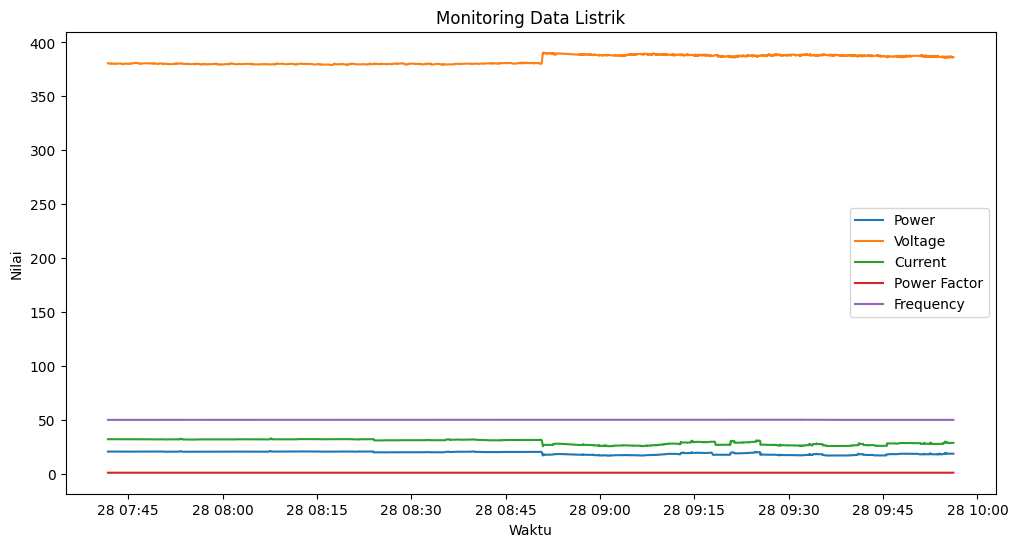

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['power'], label='Power')
plt.plot(df.index, df['voltage'], label='Voltage')
plt.plot(df.index, df['current'], label='Current')
plt.plot(df.index, df['powerfactor'], label='Power Factor')
plt.plot(df.index, df['frequency'], label='Frequency')
plt.xlabel("Waktu")
plt.ylabel("Nilai")
plt.title("Monitoring Data Listrik")
plt.legend()
plt.show()


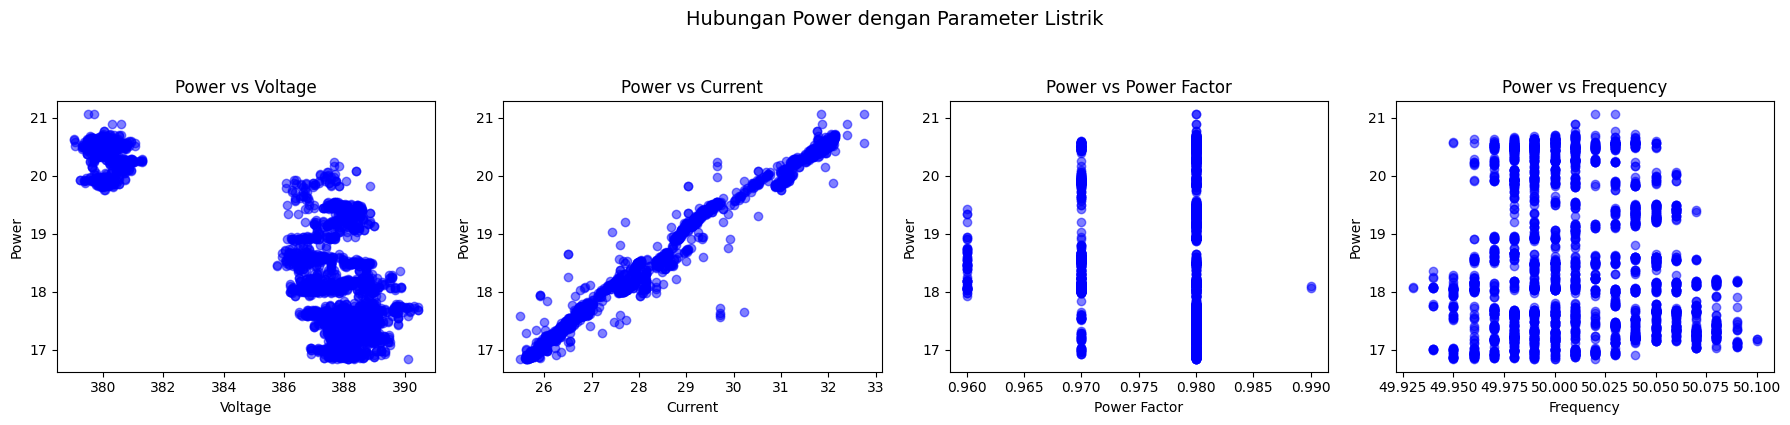

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(18,4))

# Scatter Power vs Voltage
axes[0].scatter(df['voltage'], df['power'], alpha=0.5, color='blue')
axes[0].set_xlabel("Voltage")
axes[0].set_ylabel("Power")
axes[0].set_title("Power vs Voltage")

# Scatter Power vs Current
axes[1].scatter(df['current'], df['power'], alpha=0.5, color='blue')
axes[1].set_xlabel("Current")
axes[1].set_ylabel("Power")
axes[1].set_title("Power vs Current")

# Scatter Power vs Power Factor
axes[2].scatter(df['powerfactor'], df['power'], alpha=0.5, color='blue')
axes[2].set_xlabel("Power Factor")
axes[2].set_ylabel("Power")
axes[2].set_title("Power vs Power Factor")

# Scatter Power vs Frequency
axes[3].scatter(df['frequency'], df['power'], alpha=0.5, color='blue')
axes[3].set_xlabel("Frequency")
axes[3].set_ylabel("Power")
axes[3].set_title("Power vs Frequency")

plt.suptitle("Hubungan Power dengan Parameter Listrik", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Preprocessing Data

In [5]:
print(df.isnull().sum())
df.dropna(inplace=True)

X = df[['voltage', 'current']]  # fitur
y = df['power']                 # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)


voltage        0
current        0
power          0
frequency      0
powerfactor    0
dtype: int64
Data latih: (2480, 2)
Data uji: (620, 2)


XGBoost Regression

In [6]:
model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=100,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Evaluasi

In [7]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"📊 Evaluasi Model Random Forest:")
print(f"- Mean Squared Error (MSE)     : {mse:.4f} kW²")
print(f"- Root Mean Squared Error (RMSE): {rmse:.4f} kW")
print(f"- Mean Absolute Error (MAE)     : {mae:.4f} kW")
print(f"- Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"- R-squared (R² Score)          : {r2:.4f}")

📊 Evaluasi Model Random Forest:
- Mean Squared Error (MSE)     : 0.0166 kW²
- Root Mean Squared Error (RMSE): 0.1288 kW
- Mean Absolute Error (MAE)     : 0.0547 kW
- Mean Absolute Percentage Error (MAPE): 0.29%
- R-squared (R² Score)          : 0.9897


Visualisasi

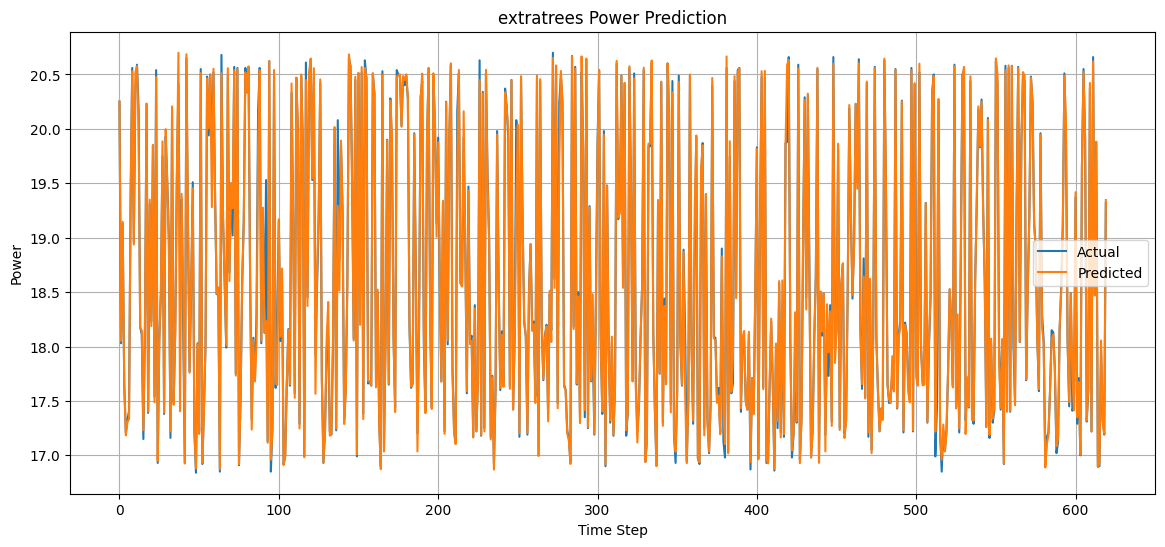

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('extratrees Power Prediction')
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

Visualisasi 100 Data awal

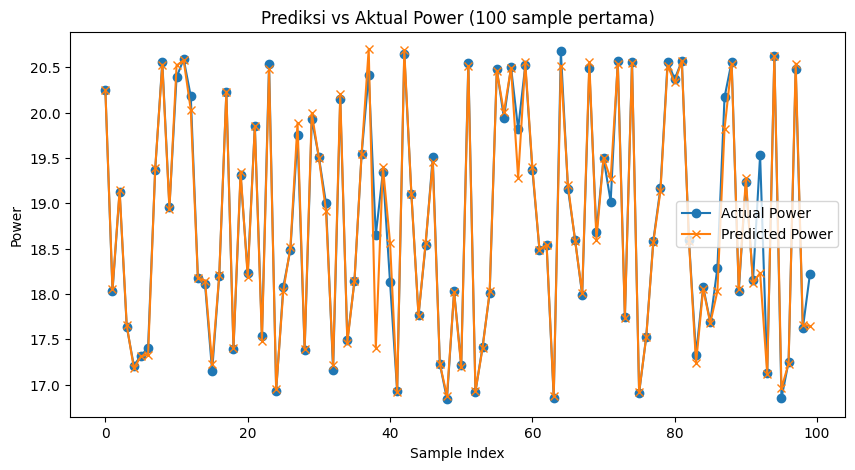

In [9]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual Power', marker='o')
plt.plot(y_pred[:100], label='Predicted Power', marker='x')
plt.title("Prediksi vs Aktual Power (100 sample pertama)")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.legend()
plt.show()

Correlation Heatmap

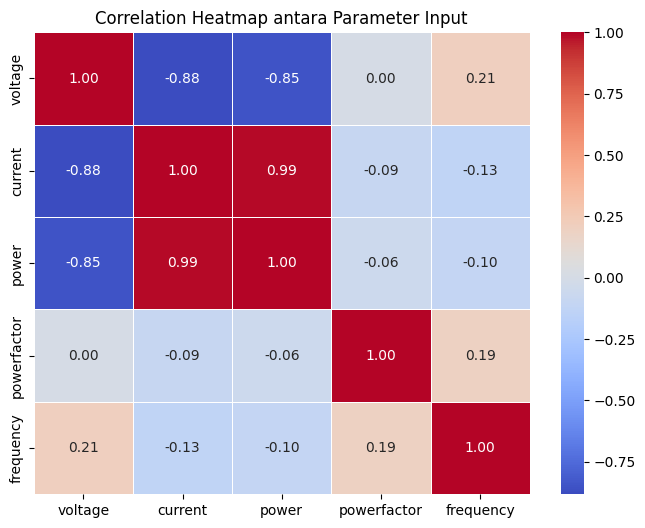

In [10]:
# Correlation matrix
corr = df[['voltage', 'current', 'power', 'powerfactor', 'frequency']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap antara Parameter Input")
plt.show()

Plot

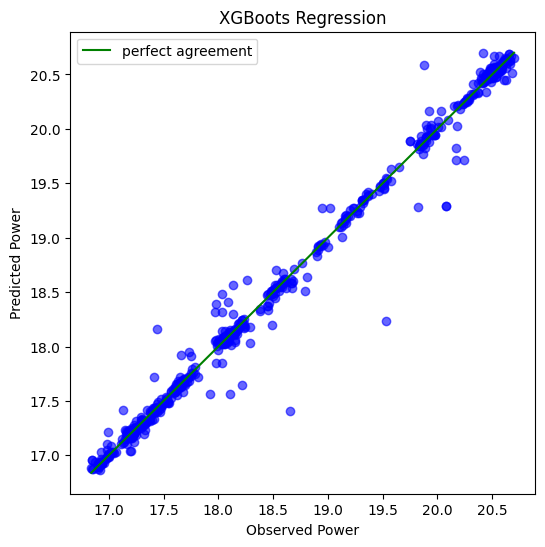

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'g-', label="perfect agreement")

plt.xlabel("Observed Power")
plt.ylabel("Predicted Power")
plt.title("XGBoots Regression")


plt.legend()
plt.show()

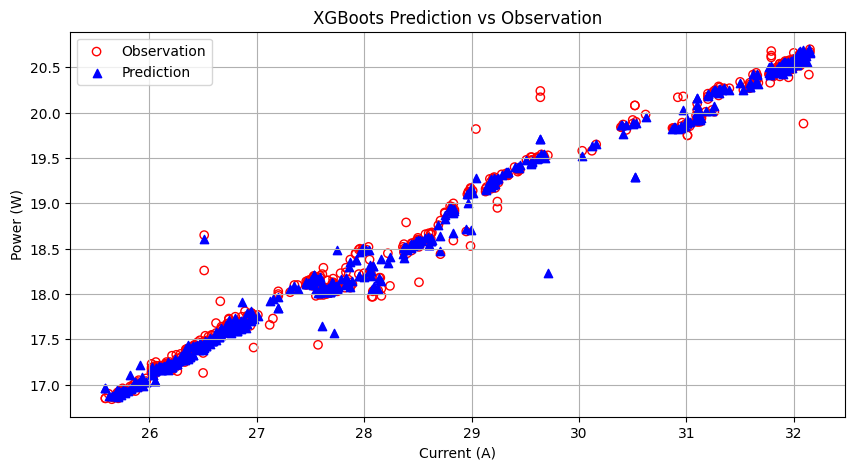

In [12]:
# Plot Observed vs Predicted dalam satu grafik
plt.figure(figsize=(10,5))

# Observasi (O merah)
plt.scatter(X_test['current'], y_test, facecolors='none', edgecolors='red', label="Observation")

# Prediksi (▲ biru)
plt.scatter(X_test['current'], y_pred, marker='^', color='blue', label="Prediction")

plt.xlabel("Current (A)")
plt.ylabel("Power (W)")
plt.title("XGBoots Prediction vs Observation")
plt.legend()
plt.grid(True)
plt.show()
